In [ ]:
using CSV
using DataFrames
using Plots
using IJulia
using StatsBase
using LinearAlgebra
using Distributions
using Interpolations
using Clustering
using ColorSchemes
using Distances
using DelimitedFiles
using LinearRegression
using Random
using Measures
using ProgressMeter
plotlyjs()

In [2]:
function sma(x::Vector, before::Int64, after::Int64)
    x_a = copy(x)
    for i in 1:after
        x_a .+= vcat(x[i+1:end],x[end-(i-1):end])
    end
    for i in 1:before
        x_a .+= vcat(x[1:i],x[1:end-(i)])
    end
    return x_a./(1+after+before)
end

sma (generic function with 1 method)

### Read the dump-file

In [3]:
function read_dump_file_v2(f_path::String; wrapped::Bool = false)
    # Define number of particles in the system
    N = 0
    open(f_path) do f
        while ! eof(f) 
            if occursin("NUMBER OF ATOMS", readline(f))
                N = parse(Int64,readline(f))
                break
            end
        end
    end
    println("Number of particles = $(N)")
    
    dfs = Dict()
    
    # Iterate through all the timesteps
    ts = 0
    open(f_path) do f
        while length(dfs) < 100 && ! eof(f) #while ! eof(f)
            # Define current timestep
            if occursin("TIMESTEP", readline(f))
                ts = parse(Int64,readline(f))
            end
            if occursin("ITEM: ATOMS", readline(f))
                Id = zeros(Int64,N)
                Type = zeros(Int64,N)
                x = zeros(Float64,N)
                y = zeros(Float64,N)
                z = zeros(Float64,N)
                if wrapped
                    xw = zeros(Float64,N)
                    yw = zeros(Float64,N)
                    zw = zeros(Float64,N)
                end
                
                for i in 1:N
                    d = split(strip(readline(f))," ")
                    Id[i] = parse(Int64,d[1])
                    Type[i] = parse(Int64,d[2])
                    x[i] = parse(Float64,d[3])
                    y[i] = parse(Float64,d[4])
                    z[i] = parse(Float64,d[5])
                    if wrapped
                        xw[i] = parse(Float64,d[6])
                        yw[i] = parse(Float64,d[7])
                        zw[i] = parse(Float64,d[8])
                    end
                        
                end
                if wrapped
                    df = DataFrame(Id=Id, Type=Type, x=x, y=y, z=z, xw=xw, yw=yw, zw=zw)
                else
                    df = DataFrame(Id=Id, Type=Type, x=x, y=y, z=z)
                end
                
                dfs[ts] = sort(df,[:Id])
                
            end
        end
    end
    return dfs, sort(collect(keys(dfs)))
end



read_dump_file_v2 (generic function with 1 method)

In [7]:
# Read the dump file:
temp = "014"
#f_path = "../Sim_results/bcc16000_v2/pos_$(temp)K.dump"
f_path = "../Sim_results/results_with_wrapped/pos_014K_1.dump"
data, ts = read_dump_file_v2(f_path, wrapped = true);

Number of particles = 16000


### Find ${r_{crit}}$ and differentiate the particles 

In [230]:
function calc_rcrit!(df::DataFrame,df0::DataFrame,timestep::Int64; do_plot::Bool = false)
    Δt = 0.0083
    sort!(df,:Id)
    sort!(df0,:Id)
    # Calculate displacements
    displ = sqrt.((df.x.-df0.x).^2 .+ (df.y.-df0.y).^2 .+ (df.z.-df0.z).^2)
    # Make histogram based on displacements
    h = normalize(fit(Histogram, displ,nbins = 25), mode = :pdf)
    centers = collect(h.edges[1])[1:end-1].+0.5*(collect(h.edges[1])[2]-collect(h.edges[1])[1])
    
    # Do interpolation
    x = range(minimum(centers), maximum(centers); length = 200) #1000
    itp = interpolate(h.weights, BSpline(Quadratic(Line(OnGrid()))))
    #itps = interpolate((centers,), h.weights, Gridded(Linear()))
    itps = Interpolations.scale(itp, range(minimum(centers), maximum(centers); length = length(centers)))
    
    # Normal distribution with same mean and std
    d = Normal(mean(displ), std(displ))
    
    # Find the intersection
    old_method = true
    if old_method
        x_pk = argmax(pdf.(d,x))
        r_crit = 0.0
        prev_x = x[x_pk+10]
        for i in x[x_pk+10:end]
            if itps(i)>pdf.(d,i)
                r_crit = [i,prev_x][argmin([abs(itps(i)-pdf.(d,i)),abs(itps(prev_x)-pdf.(d,prev_x))])]
                if do_plot
                    println("r_crit = ",r_crit)
                end
                break
            end
            prev_x = i*1.0
        end
    else
        treshold = 0.02
        x_pk = argmax(pdf.(d,x))
        diffs = abs.(pdf.(d,x)[x_pk:end].-itps(x)[x_pk:end])
        try
            r_crit = x[x_pk:end][(diffs./pdf.(d,x)[x_pk:end]).<treshold][1]
        catch
            println("timestep=",timestep)
            r_crit = 0.
        end
    end
        
    
    if do_plot
        lw = 1.7
        p1 = plot(h, alpha = 0.1,label =  "",size=(500,500),
            xlabel = "r",ylabel = "G(r)", xlim = [0,:auto])#, title ="time="*string(Δt*timestep))
        #p1 = plot!(centers,h.weights, label="Gₛ(r)")
        p1 = plot!(x,itps(x), label="Gₛ(r)",linewidth=lw)
        p1 = plot!(x,pdf.(d,x), label = "G₀(r)",linewidth=lw)
        p1 = vline!([r_crit],style=:dash, color = "grey" ,label = "r* = $(round(r_crit,digits=2))")
        display(p1)
        #savefig(p1, "VanHoveA_fixed.pdf")
        
        
        p2 = plot(centers,(4*π*(centers.^2)).*h.weights, label="4πr²Gₛ(r)",
            xlabel = "r",ylabel = "4πr²G(r)", seriestype = :scatter)
        p2 = plot!(x,(4*π*(x.^2)).*itps(x), label = "4πr²Gₛ interpolated(r)")
        p2 = plot!(x,(4*π*(x.^2)).*pdf.(d,x), label = "4πr²G₀(r)")
        p2 = vline!([r_crit],label = "r_crit")
        #display(p2)
    end

    df[!,:displ] = displ;
    return r_crit
end

function plot_particles(df_A::DataFrame,df_B::DataFrame, 
        r_crit_A::Float64, r_crit_B::Float64; wrapped::Bool = true)
    ms = 4.5#1.5 # Marker size
    msw = 0.3 # Markerstrokewidth
    size = (700,700)
    
    # Plot the results for A
    mobA = filter(:displ => m -> m >= r_crit_A, df_A)
    n_mobA = filter(:displ => m -> m < r_crit_A, df_A)

    if wrapped
        plt3d= plot(mobA.xw, mobA.yw, mobA.zw, label= "Mobile A",
             seriestype=:scatter, markersize = ms,size = size,markerstrokewidth=msw,
            xlabel = "x",ylabel = "y",zlabel = "z",)
#         plt3d= plot!(n_mobA.xw, n_mobA.yw, n_mobA.zw, label= "Non-mobile A",
#              seriestype=:scatter, markersize = ms,markerstrokewidth=msw)
    else
        plt3d= plot(mobA.x, mobA.y, mobA.z, label= "Mobile A",
             seriestype=:scatter, markersize = ms,size = size,markerstrokewidth=msw,
            xlabel = "x",ylabel = "y",zlabel = "z",)
        plt3d= plot!(n_mobA.x, n_mobA.y, n_mobA.z, label= "Non-mobile A",
             seriestype=:scatter, markersize = ms,markerstrokewidth=msw)
    end
    
    # Plot the results for B
    mobB = filter(:displ => m -> m >= r_crit_B, df_B)
    n_mobB = filter(:displ => m -> m < r_crit_B, df_B)
    if wrapped
        plt3d= plot!(mobB.xw, mobB.yw, mobB.zw, label= "Mobile B",
             seriestype=:scatter, markersize = ms,size = size,markerstrokewidth=msw,
            xlabel = "x",ylabel = "y",zlabel = "z",)
#         plt3d= plot!(n_mobB.xw, n_mobB.yw, n_mobB.zw, label= "Non-mobile B",
#              seriestype=:scatter, markersize = ms,markerstrokewidth=msw)
    else
        plt3d= plot!(mobB.x, mobB.y, mobB.z, label= "Mobile B",
             seriestype=:scatter, markersize = ms,size = size,markerstrokewidth=msw,
            xlabel = "x",ylabel = "y",zlabel = "z",)
        plt3d= plot!(n_mobB.x, n_mobB.y, n_mobB.z, label= "Non-mobile B",
             seriestype=:scatter, markersize = ms,markerstrokewidth=msw)
    end
    #savefig(plt3d, "mobile_particles3D_2.pdf")
    #println("fig saved")
    display(plt3d)
    
end

function plot_particles_2d(df_A::DataFrame,df_B::DataFrame, 
        r_crit_A::Float64, r_crit_B::Float64; color_displ::Bool = true)
    ms = 5.0#1.5 # Marker size
    msw = 0.3 # Markerstrokewidth
    size = (700,700)
    
    # Filter out particles in z plane
    lim = 1.2
    df_A_xy = filter(:zw => z_c -> abs(10-z_c) <= lim, df_A)
    df_B_xy = filter(:zw => z_c -> abs(10-z_c) <= lim, df_B)
    
    println("Size A = ", length(df_A_xy.xw))
    println("Size B = ", length(df_B_xy.xw))
    
    if color_displ
        cA = get(ColorSchemes.viridis, (df_A_xy.displ .- minimum(df_A_xy.displ))./ 
            (maximum(df_A_xy.displ) - minimum(df_A_xy.displ)))
        cB = get(ColorSchemes.viridis, (df_B_xy.displ .- minimum(df_B_xy.displ))./ 
            (maximum(df_B_xy.displ) - minimum(df_B_xy.displ)))
        
#         plt2d= plot(df_A_xy.xw, df_A_xy.yw, label= "", color = cA,
#              seriestype=:scatter, markersize = ms,size = size,markerstrokewidth=msw,
#             xlabel = "x",ylabel = "y")
        plt2d= plot(df_B_xy.xw, df_B_xy.yw, label= "", color = cB, framestyle = :box,
             seriestype=:scatter, markersize = ms*1.2 ,markerstrokewidth=msw, xlabel = "x",ylabel = "y")
        
        # Add colorbar
        xx = range(0,0.5,100)
        yy = range(0,1,100)
        zz = zero(xx)' .+ yy
        p_cb = heatmap(xx, yy, zz, ticks=false, ratio=10, legend=false, fc=cgrad(:viridis, 40, categorical=true),
            xlims=(0,0.5), ylims = (0,1), framestyle=:box, margins = 0.0mm);
        annotate!(1.15, 0, text(round(minimum(df_B_xy.displ),digits = 2), 10, "Computer Modern"))
        annotate!(1.15, 1, text(round(maximum(df_B_xy.displ),digits = 2), 10, "Computer Modern"))
        
        l = @layout [ a{0.80w} b ]
        plt2d = plot(plt2d, p_cb, layout = l, margins=0mm, size = (400, 320))
        
    else
        # Plot the results for A
        mobA = filter(:displ => m -> m >= r_crit_A, df_A_xy)
        n_mobA = filter(:displ => m -> m < r_crit_A, df_A_xy)

        plt2d= plot(mobA.xw, mobA.yw, label= "Mobile A",
             seriestype=:scatter, markersize = ms,size = size,markerstrokewidth=msw,
            xlabel = "x",ylabel = "y",zlabel = "z",)
        plt2d= plot!(n_mobA.xw, n_mobA.yw, label= "Non-mobile A",
             seriestype=:scatter, markersize = ms,markerstrokewidth=msw)


        # Plot the results for B
        mobB = filter(:displ => m -> m >= r_crit_B, df_B_xy)
        n_mobB = filter(:displ => m -> m < r_crit_B, df_B_xy)
        plt2d= plot!(mobB.xw, mobB.yw, label= "Mobile B",
             seriestype=:scatter, markersize = ms,size = size,markerstrokewidth=msw,
            xlabel = "x",ylabel = "y",zlabel = "z",)
        plt2d= plot!(n_mobB.xw, n_mobB.yw, label= "Non-mobile B",
                 seriestype=:scatter, markersize = ms,markerstrokewidth=msw)
    end

#     savefig(plt2d, "mobile_particles2D_1.pdf")
#     println("fig saved")
    display(plt2d)
    
end

plot_particles_2d (generic function with 1 method)

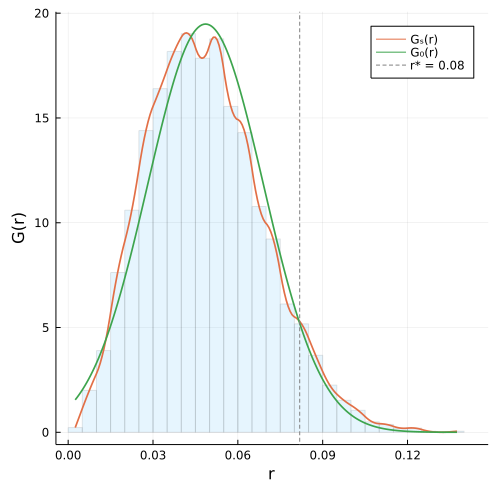

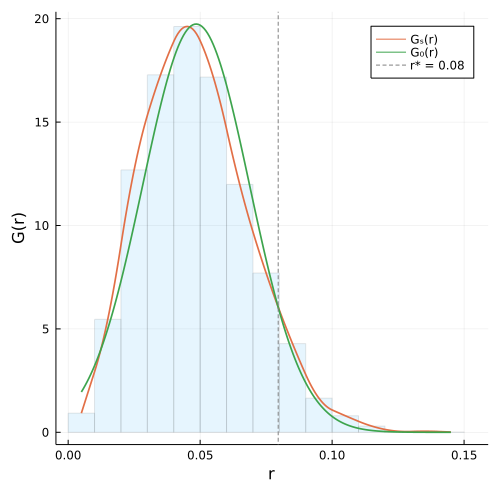

r_crit = 0.08187185929648241
r_crit = 0.07957286432160805


In [228]:
timestep = 10_000
df_A = filter(:Type => t -> t == 1, data[timestep])
df_A0 = filter(:Type => t -> t == 1, data[0])
df_B = filter(:Type => t -> t == 2, data[timestep])
df_B0 = filter(:Type => t -> t == 2, data[0])

do_plot = true
r_crit_A = calc_rcrit!(df_A,df_A0,timestep, do_plot = do_plot)
r_crit_B = calc_rcrit!(df_B,df_B0,timestep, do_plot = do_plot);

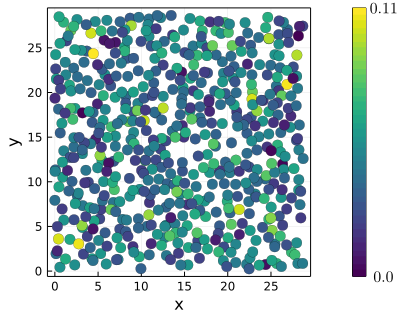

Size A = 531
Size B = 564


In [229]:
plot_particles_2d(df_A,df_B, r_crit_A, r_crit_B)

### Calculating $r_{crit}$ for all timesteps

In [5]:
function mob_particles(f_path::String = "../Sim_results/results_with_wrapped/pos_014K_lux.dump"; save::Bool = false, plot_stat::Bool = false, only_B = true)
    f = split(f_path,"/")
    f[end] = split(f[end],".")[1]*"_mobile"
    folder_path = join(f,"/")
    
    # Dictionary to store alle data
    X_dict = Dict()
    
    # Read the dump-file
    data, ts = read_dump_file_v2(f_path, wrapped = true)
    
    # Initialize arrays
    nums_A = zeros(Int64, length(ts))
    rcrits_A = zeros(Float64, length(ts))
    nums_B = zeros(Int64, length(ts))
    rcrits_B = zeros(Float64, length(ts))
    
    for (i,timestep) in enumerate(ts[2:end])

        # Slice the dataframe
        df_A = filter(:Type => t -> t == 1, data[timestep])
        df_A0 = filter(:Type => t -> t == 1, data[0])
        df_B = filter(:Type => t -> t == 2, data[timestep])
        df_B0 = filter(:Type => t -> t == 2, data[0])
        
        # Add row for mobility
        do_plot = false
        rcrits_A[i+1] = calc_rcrit!(df_A,df_A0,timestep, do_plot = do_plot)
        rcrits_B[i+1] = calc_rcrit!(df_B,df_B0,timestep, do_plot = do_plot)
        # Filter the mobile particles
        X_A = filter(:displ => m -> m > rcrits_A[i+1], df_A)
        X_B = filter(:displ => m -> m > rcrits_B[i+1], df_B)
        nums_A[i+1] = size(X_A)[1]
        nums_B[i+1] = size(X_B)[1]
        
        if only_B
            X_dict[timestep] = X_B
        else
            X_dict[timestep] = vcat(X_A, X_B)
        end
        
        if save
            # Write to CSV
            f_name = join([folder_path,"$(timestep).csv"],"/")
            CSV.write(f_name,X)
            println("Saved csv at ", f_name)
        end
    end
    if plot_stat
        t = ts.*0.0083
        p1 = plot(t,nums_A,label = "A",
            ylabel = "# Mobile particles", xaxis=(:log10, [1e-2, :auto]),xticks = (10*ones(7)).^Array(-2:4))
        p1 = plot!(t,nums_B,label = "B")
        
        p2 = plot(t,rcrits_A,label = "A",
            xlabel = "time", ylabel = "r_crit", xaxis=(:log10, [1e-2, :auto]),xticks = (10*ones(7)).^Array(-2:4))
        p2 = plot!(t,rcrits_B,label = "B")
        
        display(plot(p1,p2,layout = (2,1),size = (800,700)))
        
    end
    
    return X_dict, ts.*0.0083, hcat(rcrits_A, rcrits_B)
end

function load_mob_particles(root_path::String = "../Sim_results/pos_014K_lux_mobile")
    X_dict = Dict()
    for (root, dirs, files) in walkdir(root_path)
        for file in files
            println(joinpath(root, file)) # path to files
            X_dict[parse(Int64,split(file,".")[1])] = CSV.read(joinpath(root, file), DataFrame)
        end
    end
    return X_dict
end


load_mob_particles (generic function with 2 methods)

In [6]:
f_path = "../Sim_results/results_with_wrapped/pos_014K_1.dump"
X_dict, _, r_crits = mob_particles(f_path, plot_stat=true, only_B = false);
#X_dict = load_mob_particles()

Number of particles = 16000


## Plot r_crit for all temps

In [ ]:
p_r = plot(xlabel = "t", ylabel = "r*",xaxis=(:log10, [1e-2, :auto]),xticks = (10*ones(7)).^Array(-2:4),
        size = (900,450),  margin=5Plots.mm, legend=:topleft, yaxis=(:log10, [5e-3, 1e2]), minorticks=10)

lw = 1.5

# Add x^2 line for ballisitc regime 
t_f = (10*ones(7)).^Array(-2:4)
#p_r = plot!(t_f, t_f, label = "\$O\$(t)", style=:dash)

# Add r* lines for all temps
for temp in ["005", "014", "100"]
    path = "../Sim_results/results_with_wrapped/pos_$(temp)K_1.dump"
    _, t, r_crit = mob_particles(path, plot_stat = false)
    r_mat = zeros(length(t),5)
    r_mat[:,1] = r_crit[:,1]
    #p_r = plot!(p_r, t,r_crit[:,1], label = "T = $(parse(Float64,temp)/100) 1", linewidth = lw)
    
    for i in 1:5
        path = "../Sim_results/results_with_wrapped/pos_$(temp)K_$(i).dump"
        _, t, r_crit = mob_particles(path, plot_stat = false)
        r_mat[:,i] = r_crit[:,1]
        #p_r = plot!(p_r, t,r_crit[:,1], label = "T = $(parse(Float64,temp)/100) $(i)", linewidth = lw)
    end
    r_mean = mean(r_mat,dims = 2)
    if temp == "005"
        p_r = plot!(p_r, t,r_mean, label = "T = $(parse(Float64,temp)/100)", linewidth = lw, color = :blue)
    elseif temp == "014"
        p_r = plot!(p_r, t,r_mean, label = "T = $(parse(Float64,temp)/100)", linewidth = lw, color = :orange)
    else
        p_r = plot!(p_r, t,r_mean, label = "T = $(parse(Float64,temp)/100)", linewidth = lw, color = :green)
    end
    lr = linregress(log10.(t[2:10]), log10.(r_mean[2:10]))
    p_r = plot!(t[1:32], 10 .^ (((log10.(t[1:32])).*coef(lr)[1]).+coef(lr)[2]), label = "", style=:dash, color = "black")
    if temp == "100"
        lr2 = linregress(log10.(t[40:60]), log10.(r_mean[40:60]))
        p_r = plot!(t, 10 .^ (((log10.(t)).*coef(lr2)[1]).+coef(lr2)[2]), label = "", style=:dash, color = "grey")
        
        x = 10 .^ collect(range(log10(t[2]), log10(t[end]),length = 500))
        tp = x[argmin(abs.((10 .^ (((log10.(x)).*coef(lr2)[1]).+coef(lr2)[2])) .- (10 .^ (((log10.(x)).*coef(lr)[1]).+coef(lr)[2]))))]
        p_r = plot!([tp], [10 .^ (((log10.([tp])).*coef(lr2)[1]).+coef(lr2)[2])], seriestype = :scatter, 
            label = "", markersize = 3.0, markerstrokewidth = 1.0, color = "red")
        annotate!(p_r, 0.04, 0.4, text("c₂="*string(round(coef(lr2)[1], digits = 2)), :grey, :right, 9))
        annotate!(p_r, 5, 10, text("c₁="*string(round(coef(lr)[1], digits = 2)), :black, :right, 9))
        annotate!(p_r, 0.23, 1.05, text("("*string(round(tp,digits = 2))*", "*string(round(10 ^ (((log10(tp))*coef(lr2)[1])+coef(lr2)[2]),digits = 2))*")", :black, :right, 8))
    end
    
    if temp == "014"
        lr2 = linregress(log10.(t[81:end-4]), log10.(r_mean[81:end-4]))
        p_r = plot!(t[32:end], 10 .^ (((log10.(t[32:end])).*coef(lr2)[1]).+coef(lr2)[2]), label = "", style=:dash, color = "grey")
        annotate!(p_r, 8.0, 0.09, text("c₃="*string(round(coef(lr2)[1], digits = 2)), :grey, :right, 9))
        
    end
end

display(p_r)
# savefig(p_r, "r_crits_3.pdf")


### Clustering with K-means

In [ ]:
function k_means_clustering(X_dict::Dict{Any, Any},timestep::Int64; do_plot = false)
#     X = Array(X_dict[timestep][:,[:xw,:yw,:zw]])'

#     # Find best k-value
#     max_k = minimum([floor(Int, nrow(X_dict[timestep])*0.5), 150])
#     N_clusters = Array(2:4:max_k)
#     scores = zeros(Float64, length(N_clusters))
#     for (i, k) in enumerate(N_clusters)
#         samples = 50
#         best = zeros(2)
#         #Find max silluette score for samples
#         for j in 1:samples
#             R = kmeans(X, k; display=:none)
#             score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
#             if score > best[1]
#                 best[1] = score
#                 sort!(best)
#             end
#             #scores[i] = maximum([silluettes[i], mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))])
#         end
#         scores[i] = mean(best)
#     end
    
#     if do_plot
#         sma_len = 1
#         s_plot = plot(N_clusters, scores, xlabel = "Num clusters", ylabel = "Siluette score", label = "score")
#         s_plot = plot!(N_clusters, sma(scores,sma_len,sma_len), xlabel = "Num clusters", ylabel = "Siluette score", label = "sma $(sma_len)")
#         display(s_plot)
#     end
    
#     # Choose the cluster number with highest score
#     k = N_clusters[argmax(scores)]

#     R = kmeans(X, k; display=:none)
#     for j in 1:400
#         R_new = kmeans(X, k; display=:none)
#         if mean(silhouettes(R_new, pairwise(Euclidean(), X, dims=2))) > mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
#             if do_plot
#                 println("Mean silhouette score: ",mean(silhouettes(R_new, pairwise(Euclidean(), X, dims=2))))
#             end
#             R = R_new
#         end
#     end
    
    #######

    # Extract the wrapped cordinates into a matrix
    X = Array(X_dict[timestep][:,[:xw,:yw,:zw]])'

    # Locate area for best k-value (Number of clusters)
    max_k = minimum([floor(Int, nrow(X_dict[timestep])*0.6), 150])
    N_clusters = Array(2:4:max_k)
    best_scores = zeros(Float64, length(N_clusters))
    for (i, k) in enumerate(N_clusters)
        samples = 30
        best = zeros(2)
        #Find max silluette score for samples
        for j in 1:samples
            R = kmeans(X, k; display=:none)
            score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
            if score > best[1]
                best[1] = score
                sort!(best)
            end
        end
        # For each k, store the average of the 2 best scores of 15 samples
        best_scores[i] = mean(best)
    end
    # The best k should be around the k that gave the best score
    k_g = N_clusters[argmax(sma(best_scores,1,1))]

    # Refine the search to find the best k-value
    samples = 500
    best_R = kmeans(X, k_g; display=:none)
    best_score = 0
    best_k = 0
    lower = k_g-10>2 ? k_g-10 : 2 # Lower bound for k is 2
    N_clusters_fine = Array(lower:k_g+10) # Search area is the previous best k, +- 10
    for (i, k) in enumerate(N_clusters_fine)
        #Find best silluette score over 200 samples
        for j in 1:samples
            R = kmeans(X, k; display=:none)
            score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
            if score > best_score
                best_score = score
                best_k = k
                best_R = R
            end
        end
    end
    
    if do_plot
        sma_len = 1
        s_plot = plot(N_clusters, best_scores, xlabel = "Num clusters", ylabel = "Siluette score", label = "score")
        s_plot = plot!(N_clusters, sma(best_scores,sma_len,sma_len), label = "sma $(sma_len)")
        s_plot = plot!([best_k], [best_score], seriestype = :scatter, 
            label = "Best score", markersize = 3.0, markerstrokewidth = 1.0, color = "red")
        display(s_plot)

        println("Time = ", timestep*0.0083)
        println("k-value used: ", best_k)
        println("Final mean silhouette score: ",mean(silhouettes(best_R, pairwise(Euclidean(), X, dims=2))))
        
        # Plot the results
        colors = get(ColorSchemes.rainbow,best_R.assignments./best_k)

        ms = 4.5 #1.5 # Marker size
        msw = 0.3 # Markerstrokewidth
        size = (700,700)
        
        plt3d= plot(X[1,:], X[2,:], X[3,:],
             seriestype=:scatter, markersize = ms,size = size, markerstrokewidth=msw,
            xlabel = "x",ylabel = "y",zlabel = "z", color = colors, label = "");
        display(plt3d)
        #savefig(plt3d, "clustered_particles3D_2.pdf")
    end
    # Return the final k value and the corresponding silhouettes score
    return best_k, best_R
end

In [ ]:
start = time()
timestep = 10#_000
_, _ = k_means_clustering(X_dict,timestep, do_plot = true)
println("Time = ", time()-start)

### Calculate the best silhouette score for all timesteps

In [ ]:
function silhouette_score_uniform(N_samples::Vector{Int64})
    p1 = plot(size = (700,400),xlabel = "κ", ylabel = "⟨s⟩", margin=5Plots.mm,
            xguidefontsize=10,yguidefontsize=10, ylim = [0,0.4])
    for (i,N) in enumerate(N_samples)
        # Find best k-value
        if N <= 100
            N_clusters = Array(10:5:N)
        else
            N_clusters = vcat(Array(10:10:N),[N])
        end
        best_scores = zeros(Float64, length(N_clusters))
        @showprogress for (i, k) in enumerate(N_clusters)
            samples = 1500
            best = zeros(1)
            #Find max silluette score for samples
            for j in 1:samples
                X = rand(3,N).*28.724
                R = kmeans(X, k; display=:none)
                score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
                if score > best[1]
                    best[1] = score
                    sort!(best)
                end
            end
            best_scores[i] = mean(best)
        end

        p1 = plot!(p1, N_clusters, best_scores, label = "N=$(N)")
    end
    display(p1)
    #savefig(p1, "silhouette_uniform_v2.pdf")
    return p1
end

uniform_plot = silhouette_score_uniform([160,167]);

In [ ]:
#savefig(uniform_plot, "silhouette_uniform_v3.pdf")

In [ ]:
k = 20
N = 500
start = time()
for j in 1:1000
    X = rand(3,N)
    R = kmeans(X, k; display=:none)
    score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
end
println(time()-start)

start = time()
for j in 1:1000
    X = rand(3,N)
    R = kmeans(X, k; display=:none)
    score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
end
println(time()-start)

start = time()
for j in 1:1000
    X = rand(3,N)
    R = kmeans(X, k; display=:none)
    score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
end
println(time()-start)

In [ ]:
# p7.series_list[1].plotattributes[:linewidth] = 1.7
# p7.series_list[2].plotattributes[:linewidth] = 1.7
# p7.series_list[3].plotattributes[:linewidth] = 1.7
# savefig(p7, "silhouette_uniform_v3.pdf")

In [ ]:
function silhouettes_scores(X_dict::Dict{Any,Any})
    """
    Function that calculates the silhouette scores and cluster diameter for each timesteps
    for the mobile particles given in X_dict.
    
    X_dict includes particle: id, type, position, displacements
    """
    
    # Array containing all the timesteps  
    ts = sort(collect(keys(X_dict)))
    
    #Initialize arrays to store results
    scores = zeros(Float64, length(ts))     # Best silhouette score
    cluster_nums = zeros(Int64, length(ts)) # Number of cluster that give the best score
    avg_cl = zeros(Float64, length(ts))     # Average cluster diameter
    
    # Loop over timesteps
    for (i,t) in enumerate(ts)
        # Extract the wrapped cordinates into a matrix
        X = Array(X_dict[t][:,[:xw,:yw,:zw]])'
        
        # Locate area for best k-value (Number of clusters)
        max_k = minimum([floor(Int, nrow(X_dict[t])*0.6), 150])
        N_clusters = Array(2:4:max_k)
        best_scores = zeros(Float64, length(N_clusters))
        for (i, k) in enumerate(N_clusters)
            samples = 30
            best = zeros(2)
            #Find max silluette score for samples
            for j in 1:samples
                R = kmeans(X, k; display=:none)
                score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
                if score > best[1]
                    best[1] = score
                    sort!(best)
                end
            end
            # For each k, store the average of the 2 best scores of 15 samples
            best_scores[i] = mean(best)
        end
        # The best k should be around the k that gave the best score
        k_g = N_clusters[argmax(sma(best_scores,1,1))]
        best_R = kmeans(X, k_g; display=:none)
        
        # Refine the search to find the best k-value
        samples = 500
        best_score = 0
        best_k = 0
        lower = k_g-10>2 ? k_g-10 : 2 # Lower bound for k is 2
        N_clusters = Array(lower:k_g+10) # Search area is the previous best k, +- 10
        for (i, k) in enumerate(N_clusters)
            #Find best silluette score over 200 samples
            for j in 1:samples
                R = kmeans(X, k; display=:none)
                score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
                if score > best_score
                    best_score = score
                    best_k = k
                    best_R = R
                end
            end
        end
        # Store the best k and the respective silhouette score
        scores[i] = best_score
        cluster_nums[i] = best_k
        
        # Calculate the cluster lengths for the best clustering solution, R
        lengths = zeros(best_k)
        # Loop over all the clusters
        for k in 1:best_k
            Xs = X[:,findall(best_R.assignments .== k)] # Filter out the particles assigned to cluster k
            # Calculate all the pair distances and save the longes intra-cluster distance
            for j in 1:(size(Xs)[2])
                len = maximum(sqrt.((Xs[1,j:end].-Xs[1,j]).^2 .+(Xs[2,j:end].-Xs[2,j]).^2 .+(Xs[3,j:end].-Xs[3,j]).^2))
                if len > lengths[k]
                    lengths[k] = len
                end
            end
        end
        # Store the average cluster-diameter
        avg_cl[i] = mean(lengths)
        
    end
    # Return the timesteps, silhouette scores, number of clusters and average cluster diameter
    return ts, scores, Int.(cluster_nums), avg_cl
end

function num_mobile(X_dict::Dict{Any,Any})
    # Array containing all the timesteps  
    ts = sort(collect(keys(X_dict)))
    mobile_nums = zeros(Int64, length(ts))
    
    for (i,t) in enumerate(ts)
        mobile_nums[i] = size(X_dict[t])[1]
    end
    return mobile_nums
end

function cluster_lengths(X_dict::Dict{Any,Any}, ks::Vector{Int64})
    cl = Dict()
    last_R = 0
    
    ts = sort(collect(keys(X_dict)))
    for (i,t) in enumerate(ts)
        X = Array(X_dict[t][:,[:xw,:yw,:zw]])'
        # Find best sample
        samples = 100
        best_R = kmeans(X, ks[i]; display=:none)
        best_score = 0
        #Find max silluette score for samples
        for j in 1:samples
            R = kmeans(X, ks[i]; display=:none)
            score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
            if score > best_score
                best_score = score*1.0
                best_R = R
            end
        end
       
        # Calculate the cluster lengths
        lengths = zeros(ks[i])
        # Loop over the clusters
        for k in 1:ks[i]
            Xs = X[:,findall(best_R.assignments .== k)]
            for j in 1:(size(Xs)[2])
                len = maximum(sqrt.((Xs[1,j:end].-Xs[1,j]).^2 .+(Xs[2,j:end].-Xs[2,j]).^2 .+(Xs[3,j:end].-Xs[3,j]).^2))
                if len > lengths[k]
                    lengths[k] = len
                end
            end
        end
        cl[t] = lengths
    end
    return cl
end

function silhouette_convergence(X_dict::Dict{Any,Any}, ts, k)
    X = Array(X_dict[ts][:,[:xw,:yw,:zw]])'
    N_tot = 100_000
    K = 3
    n = collect(1:N_tot)
    silhouette_score = zeros(N_tot,K)
    best = zeros(K)
    converged = zeros(K)
    @showprogress for i in 1:N_tot
        for j in 1:K
            R = kmeans(X, k; display=:none)
            score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
            if R.converged
                converged[j] +=1.0
            end
            #all_scores[i,j] = score
            #silhouette_score2[i,j] = mean(all_scores[1:i,j])
            if score > best[j]
                best[j] = score
            end
            silhouette_score[i,j] = best[j]
        end
    end
    print("Converged rate:",mean(converged ./ N_tot))
    return n, mean(silhouette_score,dims=2)#, mean(silhouette_score2,dims = 2)
end

### Convergence analysis

In [ ]:
temp = "014"
i = 1
timest = 10_000

f_path = "../Sim_results/results_with_wrapped/pos_$(temp)K_$(i).dump"
X_dict, _, rcrits = mob_particles(f_path); # Calculate the mobile particles


In [ ]:
# 10
n10, scores10 = silhouette_convergence(X_dict, timest, 10);

In [ ]:
# 50
n50, scores50 = silhouette_convergence(X_dict, timest, 50);

In [ ]:
# 100
n100, scores100 = silhouette_convergence(X_dict, timest, 100);

In [ ]:
p_conv = plot(xaxis=(:log10, [1e-0, :auto]), xlabel = "Iterations", ylabel = "⟨s⟩",
        xticks = (10*ones(6)).^Array(0:5), xminorticks=5, size = (600,400), legend = false);

p_conv = plot!(p_conv,n10, scores10, label = "κ = 10", linewidth = 1.5)
p_conv = plot!(p_conv,n50, scores50, label = "κ = 50", linewidth = 1.5)
p_conv = plot!(p_conv,n100,scores100,label = "κ = 100", linewidth = 1.5)
display(p_conv)

In [ ]:
savefig(p_conv, "conv_014_t10_000.pdf")

In [ ]:
temp2 = "100"
i2 = 1
timest2 = 10 #_000

f_path2 = "../Sim_results/results_with_wrapped/pos_$(temp2)K_$(i2).dump"
X_dict2, _, rcrits2 = mob_particles(f_path2); # Calculate the mobile particles


In [ ]:
# 10
n10_2, scores10_2 = silhouette_convergence(X_dict2, timest2, 10);

In [ ]:
# 50
n50_2, scores50_2 = silhouette_convergence(X_dict2, timest2, 50);

In [ ]:
# 100
n100_2, scores100_2 = silhouette_convergence(X_dict2, timest2, 100);

In [ ]:
p_conv2 = plot(xaxis=(:log10, [1e-0, :auto]), xlabel = "Iterations", ylabel = "⟨s⟩",
        xticks = (10*ones(6)).^Array(0:5), xminorticks=5, size = (600,400), legend = false);

p_conv2 = plot!(p_conv2,n10_2, scores10_2, label = "κ = 10", linewidth = 1.5)
p_conv2 = plot!(p_conv2,n50_2, scores50_2, label = "κ = 50", linewidth = 1.5)
p_conv2 = plot!(p_conv2,n100_2,scores100_2,label = "κ = 100", linewidth = 1.5)
display(p_conv2)

In [ ]:
savefig(p_conv2, "conv_100_t10_000.pdf")

In [ ]:
temp3 = "005"
i3 = 1
timest3 = 10_000

f_path3 = "../Sim_results/results_with_wrapped/pos_$(temp3)K_$(i3).dump"
X_dict3, _, rcrits3 = mob_particles(f_path3); # Calculate the mobile particles


In [ ]:
# 10
n10_3, scores10_3 = silhouette_convergence(X_dict3, timest3, 10);

In [ ]:
# 50
n50_3, scores50_3 = silhouette_convergence(X_dict3, timest3, 50);

In [ ]:
# 100
n100_3, scores100_3 = silhouette_convergence(X_dict3, timest3, 100);

In [ ]:
p_conv3 = plot(xaxis=(:log10, [1e-0, :auto]), xlabel = "Iterations", ylabel = "⟨s⟩",
        xticks = (10*ones(6)).^Array(0:5), xminorticks=5, size = (600,400), legend = false);

p_conv3 = plot!(p_conv3,n10_3, scores10_3, label = "κ = 10", linewidth = 1.5)
p_conv3 = plot!(p_conv3,n50_3, scores50_3, label = "κ = 50", linewidth = 1.5)
p_conv3 = plot!(p_conv3,n10_3,scores100_3,label = "κ = 100", linewidth = 1.5)
display(p_conv3)

In [ ]:
savefig(p_conv3, "conv_005_t10_000.pdf")

## Do all calculations

In [ ]:
struct sample_data
    X_dict::Dict{Any, Any}       # Dictionary that contains mobile particle id,type,position and displacement
    ts::Vector{Int64}            # Timesteps
    nm::Vector{Int64}            # Number of mobile particles
    rcrits::Matrix{Float64}      # Cut-off distances
    scores::Vector{Float64}      # Silhouette scores
    cluster_nums::Vector{Int64}  # Number of clusters
    cluster_len::Vector{Float64} # Average cluster lengths
end

In [ ]:
all_data = Dict() # Dictionary to contain the data for all samples for all temperatures

# Loop over temperatures 
for temp in ["005", "014", "100"]
    # Loop over samples
    @showprogress for i in 1:5
        f_path = "../Sim_results/results_with_wrapped/pos_$(temp)K_$(i).dump"
        X_dict, _, rcrits = mob_particles(f_path) # Calculate the mobile particles
        ts = sort(collect(keys(X_dict))) # Timesteps
        nm = num_mobile(X_dict) # Number of mobile particles
        
        # Check if silhouette scores are already calculated
        if isfile("silhettes_$(temp)K_$(i)_B_final.txt")
            data_mat = readdlm("silhettes_$(temp)K_$(i)_B_final.txt", '\t', Float64, '\n')
            scores       = data_mat[:,2]
            cluster_nums = Int.(data_mat[:,3])
            avg_cl       = data_mat[:,4]
        else 
            # Calculate the silhouette scores
            _, scores, cluster_nums, avg_cl = silhouettes_scores(X_dict)
            # Save the data
            open("silhettes_$(temp)K_$(i)_B_final.txt", "w") do io
               writedlm(io, [ts scores cluster_nums avg_cl])
            end
        end
        # Add the data into a the struct and store it in all_data
        all_data["temp"*"_"*temp*"_$(i)"] = sample_data(X_dict, ts, nm, rcrits, scores, cluster_nums, avg_cl)
    end

end 


In [ ]:
### Plot all the results

lw = 1.5

p1 = plot(ylabel = "Particles per cluster", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :bottomleft)

p2 = plot(ylabel = "⟨s⟩", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :topleft)

p2b = plot(ylabel = "⟨s⟩", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :topleft)

p3 = plot(ylabel = "Number of clusters", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :topleft)

p4 = plot(ylabel = "Fraction of mobile particles", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :bottomleft)

p5 = plot(ylabel = "Cluster diameters", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :bottomleft)

for temp in ["005", "014", "100"]
    time = all_data["temp_014_1"].ts .* 0.0083
    p_per_c = zeros(5,length(time))
    s_avg = zeros(5,length(time))
    nm_avg = zeros(5,length(time))
    N_clusters_avg = zeros(5,length(time))
    cl_avg = zeros(5,length(time))
    for i in 1:5
        key = "temp"*"_"*temp*"_$(i)"
        time = all_data[key].ts .* 0.0083
        p2 = plot!(p2,time ,all_data[key].scores,label = "T = $(parse(Float64,temp)/100) $(i)", linewidth = lw)
        p_per_c[i,:]        = all_data[key].nm ./ all_data[key].cluster_nums
        s_avg[i,:]          = all_data[key].scores
        N_clusters_avg[i,:] = all_data[key].cluster_nums
        nm_avg[i,:]         = all_data[key].nm ./ 8_000
        cl_avg[i,:]         = all_data[key].cluster_len
    end
    p1 = plot!(p1, time,sma(mean(p_per_c,dims = 1)[:],2,2),label = "T = $(parse(Float64,temp)/100)", linewidth = lw)
    p2b = plot!(p2b,time ,sma(mean(s_avg,dims = 1)[:],2,2),label = "T = $(parse(Float64,temp)/100) average", linewidth = lw)
    p3 = plot!(p3, time,mean(N_clusters_avg,dims = 1)',label = "T = $(parse(Float64,temp)/100)", linewidth = lw)
    p4 = plot!(p4, time,sma(mean(nm_avg,dims = 1)[:],2,2),label = "T = $(parse(Float64,temp)/100)", linewidth = lw)
    p5 = plot!(p5, time,sma(mean(cl_avg,dims = 1)[:],2,2),label = "T = $(parse(Float64,temp)/100)", linewidth = lw)

end

display(p1)
display(p2)
display(p2b)
display(p3)
display(p4)
display(p5)

savefig(p1, "particles_per_c3.pdf")
savefig(p2b, "silhouette_scores3.pdf")
#savefig(p4, "mobile_frac_sma3.pdf")
savefig(p5, "cluster_diameter3.pdf")

## Plot of silhuette scores

In [ ]:
X_dicts = Dict()
X_dicts["014"] = X_dict
X_dicts["100"] = X_dict_liq
X_dicts["005"] = X_dict_005
X_dicts["001"] = X_dict_001

avg_cluster_len = Dict()

for temp in ["005", "014", "100"]
    data_mat = readdlm("silhettes_$(temp)K_new.txt", '\t', Float64, '\n')
    cluster_nums = data_mat[:,3]
    cl = cluster_lengths(X_dicts[temp],Int.(cluster_nums))
    
    ts = sort(collect(keys(cl)))
    avg_cl = zeros(length(ts))
    for (i,t) in enumerate(ts)
        avg_cl[i] = mean(cl[t])
    end
    avg_cluster_len[temp] = avg_cl
end
        
avg_cluster_len

In [ ]:
num_mobiles = Dict()
num_mobiles["014"] = num_mobile(X_dict)
num_mobiles["100"] = num_mobile(X_dict_liq)
num_mobiles["005"] = num_mobile(X_dict_005)
num_mobiles["001"] = num_mobile(X_dict_001)

lw = 1.5

p1 = plot(ylabel = "Average cluster size", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :topleft)

p2 = plot(ylabel = "⟨s⟩", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :topleft)

p3 = plot(ylabel = "Number of clusters", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :topleft)

p4 = plot(ylabel = "Fraction of mobile particles", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :topleft)

p5 = plot(ylabel = "Cluster diameters", xlabel= "t", xaxis=(:log10, [1e-2, :auto]),size = (800,400),
    xticks = (10*ones(7)).^Array(-2:4), xminorticks=10, yminorticks=5,  margin=5Plots.mm, legend = :topleft)

for temp in ["005", "014", "100"]
    data_mat = readdlm("silhettes_$(temp)K_new.txt", '\t', Float64, '\n')
    t            = data_mat[:,1].*0.0083
    scores       = data_mat[:,2]
    cluster_nums = data_mat[:,3]
    
    p1 = plot!(p1, t,num_mobiles[temp]./cluster_nums,label = "T = $(parse(Float64,temp)/100)", linewidth = lw)

    p2 = plot!(p2, t,scores,label = "T = $(parse(Float64,temp)/100)", linewidth = lw)
    
    p3 = plot!(p3, t,cluster_nums,label = "T = $(parse(Float64,temp)/100)", linewidth = lw)
    
    p4 = plot!(p4, t,num_mobiles[temp]/16_000,label = "T = $(parse(Float64,temp)/100)", linewidth = lw)
    
    p5 = plot!(p5, t,avg_cluster_len[temp],label = "T = $(parse(Float64,temp)/100)", linewidth = lw)
end

#display(plot(p2, p3, p1,layout = (3,1),size = (800,1000)))
display(p4)
display(p2)
display(p1)
display(p3)
display(p5)
#savefig(p4, "num_mobile.pdf")

## Animation

In [32]:
gr()

Plots.GRBackend()

In [ ]:
function find_k_values(X_dict::Dict{Any, Any},timesteps::Vector{Int64})
    # Define animation object
    k_vals = Dict()
    
    # Loop over each timestep
    for timestep in timesteps
        # The positions of every cluster
        X = Array(X_dict[timestep][:,[:xw,:yw,:zw]])'

        # Find best k-value
        N_clusters = Array(2:150)
        scores = zeros(Float64, length(N_clusters))
        for (i, k) in enumerate(N_clusters)
            samples = 50
            best = zeros(10)
            #Find max silluette score for samples
            for j in 1:samples
                R = kmeans(X, k; display=:none)
                score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
                if score > best[1]
                    best[1] = score
                    sort!(best)
                end
                #scores[i] = maximum([silluettes[i], mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))])
            end
            scores[i] = mean(best)
        end

        # Choose the cluster number with highest score
        k_vals[timestep] = N_clusters[argmax(scores)]
    end
    
    return k_vals
end

function clustering_animation(X_dict::Dict{Any, Any}, k_vals::Vector{Int64}, timesteps::Vector{Int64}, 
        r_crits::Vector{Float64})
    
    # Define animation object
    anim = Plots.Animation()
    
    # Loop over each timestep
    for (t, timestep) in enumerate(timesteps)
        X = Array(X_dict[timestep][:,[:xw,:yw,:zw]])'
        
        # Calculate the clusters
        R = kmeans(X, k_vals[t]; display=:none)
        R_score = mean(silhouettes(R, pairwise(Euclidean(), X, dims=2)))
        for j in 1:200
            R_new = kmeans(X, k_vals[t]; display=:none)
            if mean(silhouettes(R_new, pairwise(Euclidean(), X, dims=2))) > R_score
                R = R_new
                R_score = mean(silhouettes(R_new, pairwise(Euclidean(), X, dims=2)))
            end
        end
        
        colors = get(ColorSchemes.rainbow,R.assignments./k_vals[t])
        c_min, c_max = 0,1
        
        if false
            cl_displ = zeros(length(R.counts))
            X_dict[timestep][!,"cl"] = R.assignments
            for (i, e) in enumerate(R.counts)
                cl_displ[i] = mean(filter(:cl => cl -> cl == i, X_dict[timestep]).displ)
            end
            
            colors = get(ColorSchemes.viridis,
                ([cl_displ[x] for x in R.assignments] .- minimum(cl_displ))./ (maximum(cl_displ)-minimum(cl_displ)))
            c_min = round(minimum(cl_displ), digits = 2)
            c_max = round(maximum(cl_displ), digits = 2)
        end

        if false
            size_map = zeros(length(R.counts))
            # Find the color of each cluster based on size
            sorted = sort(R.counts)
            for (i, e) in enumerate(R.counts)
                pos = argmin(abs.(sorted.-e))
    #             while pos ∈ size_map
    #                 pos += 1
    #             end
                size_map[i] = pos
            end
            colors = get(ColorSchemes.viridis,[size_map[x] for x in R.assignments]./k_vals[t])
        end
        
        if true
            colors = get(ColorSchemes.viridis,(X_dict[timestep].displ .- minimum(X_dict[timestep].displ)) 
                    ./ (maximum(X_dict[timestep].displ) - minimum(X_dict[timestep].displ)))
        end
        
        # Plot the results
        ms = 5.0 # Marker size
        msw = 0.5 # Markerstrokewidth
        plt3d= plot(X[1,:], X[2,:], X[3,:],
             seriestype=:scatter, markersize = ms,markerstrokewidth=msw,
            xlabel = "x",ylabel = "y",zlabel = "z", color = colors, label = "",
            title = "t = $(round(timestep*0.0083, digits = 1)), r* = $(round(r_crits[t], digits = 2))")
        
        # Add colorbar
        xx = range(0,0.5,100)
        yy = range(0,1,100)
        zz = zero(xx)' .+ yy
        p_cb = heatmap(xx, yy, zz, ticks=false, ratio=10, legend=false, fc=cgrad(:viridis, 40, categorical=true),
            xlims=(0,0.5), ylims = (0,1), framestyle=:box, margins = 0.0mm);
        annotate!(1., 0, text(c_min, 10, "Computer Modern"))
        annotate!(1., 1, text(c_max, 10, "Computer Modern"))
        
        l = @layout [ a{0.80w} b ]
        plot(plt3d, p_cb, layout = l, margins=0mm, size = (750, 600))
        
        # Add frame to the animation object
        Plots.frame(anim)
    end
    return anim
end


In [ ]:
temp, i = "014", 1

f_path = "../Sim_results/results_with_wrapped/pos_$(temp)K_$(i).dump"
X_dict, _, rcrits = mob_particles(f_path)

data_mat = readdlm("silhettes_$(temp)K_$(i)_B2.txt", '\t', Float64, '\n')
ts           = Int.(data_mat[:,1])
scores       = data_mat[:,2]
cluster_nums = Int.(data_mat[:,3])
avg_cl       = data_mat[:,4];


In [ ]:
#start_idx, end_idx = 10, 28     #      10 -     100
#start_idx, end_idx = 28, 46     #     100 -   1 000
#start_idx, end_idx = 46, 64     #   1 000 -  10 000
start_idx, end_idx = 64, 82     #  10 000 - 100 000
#start_idx, end_idx = 82, 99     # 100 000 - 950 000

#start_idx, end_idx = 28, 30

println("Timesteps = ", ts[start_idx : end_idx])
animation = clustering_animation(X_dict, cluster_nums[start_idx : end_idx], ts[start_idx : end_idx], 
    rcrits[:,2][start_idx : end_idx]);

In [ ]:
gif(animation, "cluster_animation1.gif", fps = 0.7)

In [ ]:
X = Array(X_dict[10000][:,[:xw,:yw,:zw]])'
        
# Calculate the clusters
R = kmeans(X,21; display=:none);

In [ ]:
X_dict[10000][!,"cl"] = R.assignments
X_dict[10000][:,:cl]

In [ ]:

xx = range(0,0.5,100)
yy = range(0,1,100)
zz = zero(xx)' .+ yy
p3 = heatmap(xx, yy, zz, ticks=false, ratio=10, legend=false, fc=cgrad(:viridis, 40, categorical=true),
    xlims=(0,0.5), ylims = (0,1), framestyle=:box, margins = 0.0mm);
display(p3)

In [ ]:
rcrits[:,2][start_idx : end_idx]